## Time Series Modeling

#Step 1: Time Series Decomposition
Decompose your imputed_Quantity time series to analyze its components: trend, seasonality, and residuals.

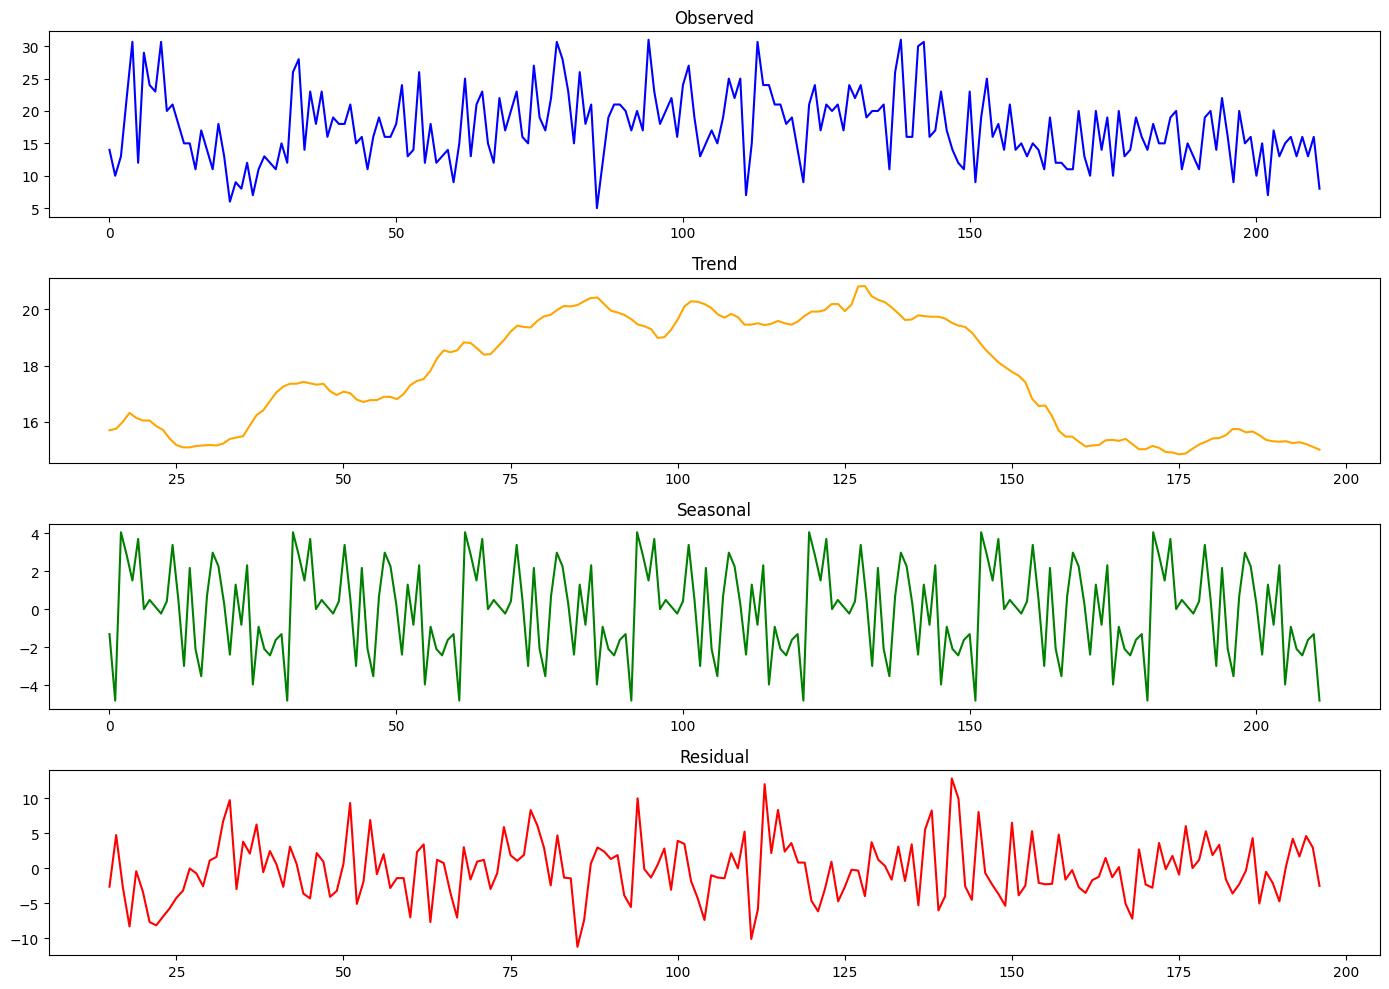

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd

file_path = '/content/Final_file.csv'
data = pd.read_csv(file_path)

# Ensure the data is sorted by date
data.sort_index(inplace=True)

# Select the time series column
series = data['imputed_Quantity']

# Decompose the time series
decomposition = seasonal_decompose(series, model='additive', period=30)  # Adjust period if necessary

# Plot the decomposition
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual')

plt.tight_layout()
plt.show()


##Step 2: Train-Test Split
Split the dataset into training (80%) and testing (20%) sets based on the time index to ensure no data leakage.

In [7]:
# Split the dataset into training and testing sets
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Display the time range of the training and testing sets
print("Training Data:", train.index.min(), "to", train.index.max())
print("Testing Data:", test.index.min(), "to", test.index.max())


Training Data: 0 to 168
Testing Data: 169 to 211


##Step 3: Plot ACF and PACF
Use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to identify ARIMA parameters:

𝑝: Order of autoregression.

𝑑: Degree of differencing (manually decide this based on trends).

𝑞: Order of moving average.

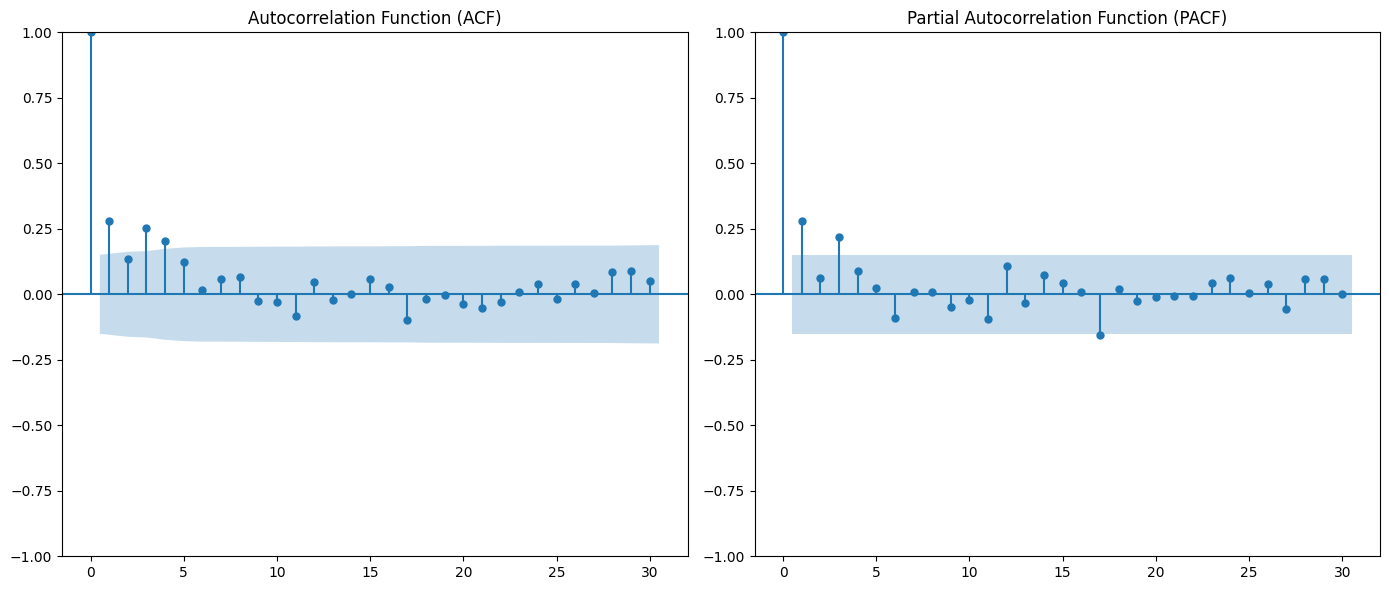

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF (to identify q)
plt.subplot(121)
plot_acf(train, lags=30, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

# PACF (to identify p)
plt.subplot(122)
plot_pacf(train, lags=30, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


##Step 4: Fit the ARIMA Model
Use the parameters (
𝑝
,
𝑑
,
𝑞
) identified from ACF and PACF plots to fit an ARIMA model. Adjust these values based on observations.

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model (example: p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))

# Fit the model
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:       imputed_Quantity   No. Observations:                  169
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -524.544
Date:                Sun, 24 Nov 2024   AIC                           1055.088
Time:                        06:36:49   BIC                           1064.460
Sample:                             0   HQIC                          1058.891
                                - 169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1819      0.082      2.229      0.026       0.022       0.342
ma.L1         -0.9057      0.047    -19.471      0.000      -0.997      -0.815
sigma2        29.9162      3.320      9.010      0.0

##Step 5: Evaluate the Model
Evaluate the model’s performance on the test dataset using metrics like:

Mean Absolute Error (MAE)
Root Mean Squared Error (RMSE)
Mean Absolute Percentage Error (MAPE)

MAE: 2.9410815222323348
RMSE: 3.6679283843633
MAPE: 21.90%


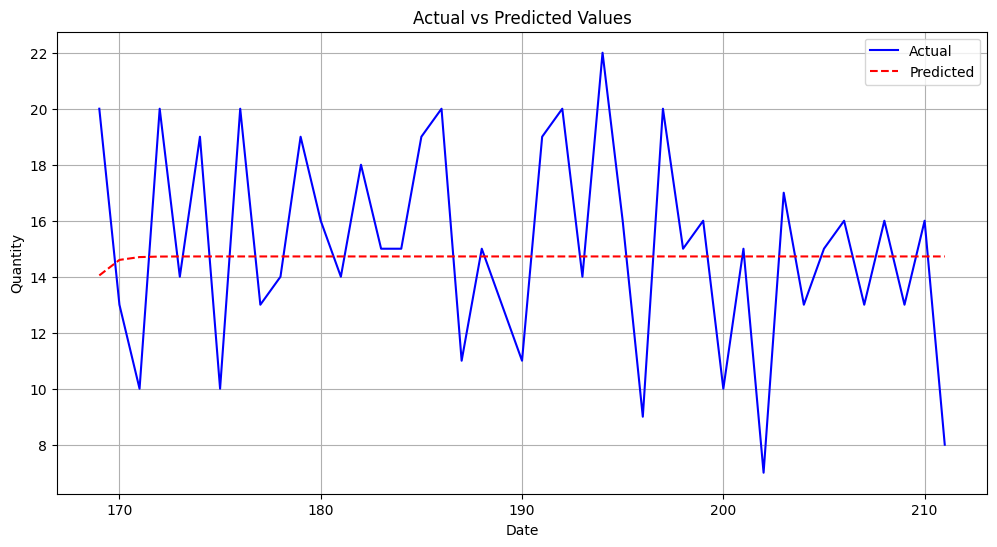

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions on the test set
predictions = fitted_model.forecast(steps=len(test))

# Evaluate metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid()
plt.show()


##Step 6: Residual Analysis
Check the residuals of the model to ensure no systematic patterns remain.

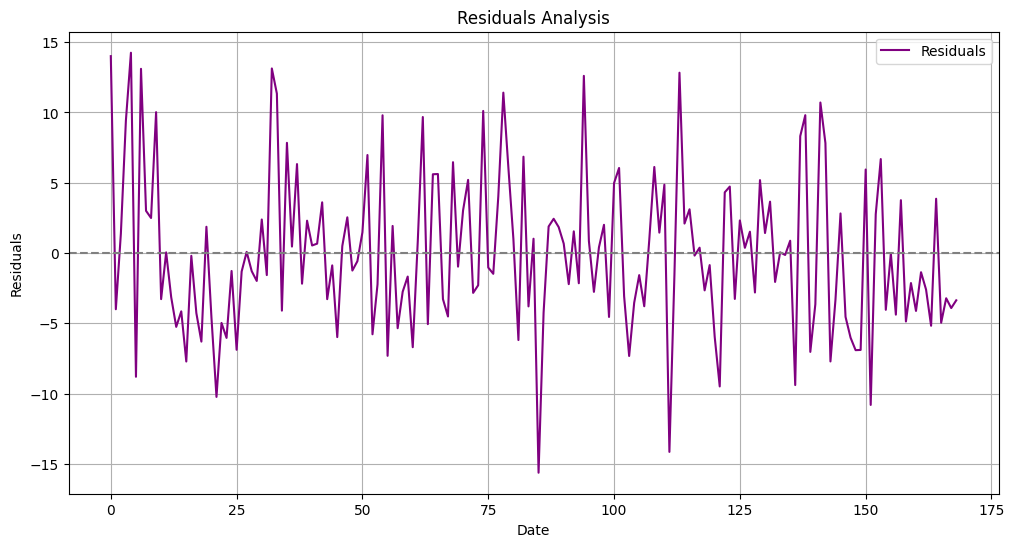

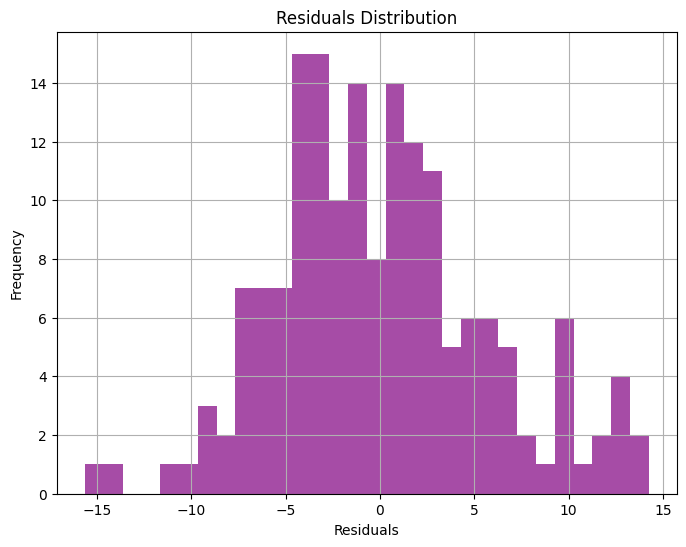

In [11]:
# Plot residuals
residuals = fitted_model.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Analysis')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()


##Step 7: Save the Results
Save the model and predictions for further analysis.

In [12]:
# Save predictions to a CSV file
predictions_df = test.copy()
predictions_df = predictions_df.to_frame(name="Actual")
predictions_df["Predicted"] = predictions
predictions_df.to_csv("predictions.csv")

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


#Time Series Model Evaluation and Diagnostics

##Step 1: Visualize Model Fit
Compare the predicted values from the model to the actual values from the training dataset to evaluate how well the model fits.

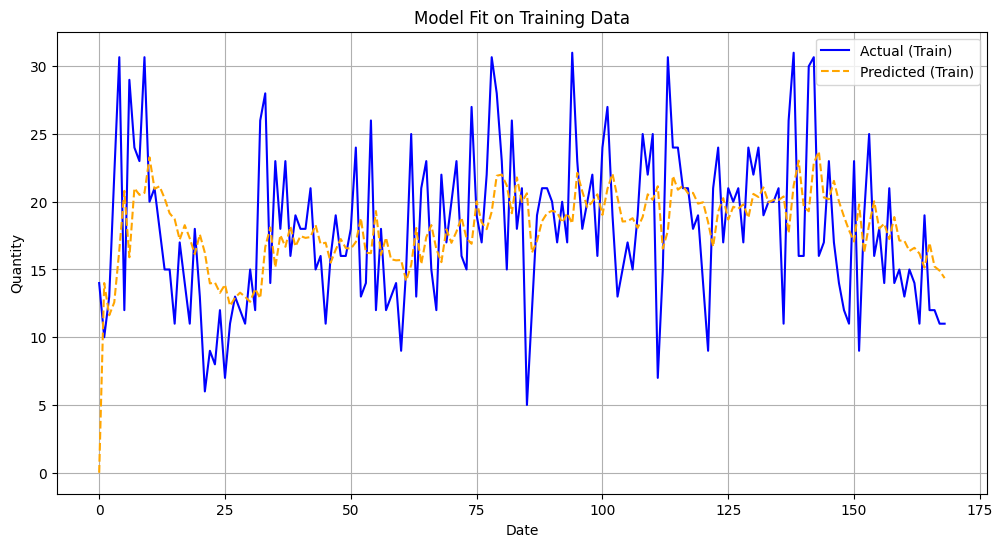

In [13]:
# Predicted values for the training data
train_predictions = fitted_model.fittedvalues

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual (Train)", color='blue')
plt.plot(train.index, train_predictions, label="Predicted (Train)", color='orange', linestyle='--')
plt.title('Model Fit on Training Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid()
plt.show()


##Step 2: Evaluate Model Performance on Test Data
Use metrics like MAE, RMSE, and MAPE to assess the accuracy of the model on the test dataset.

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate performance metrics
mae_test = mean_absolute_error(test, predictions)
rmse_test = np.sqrt(mean_squared_error(test, predictions))
mape_test = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")


Mean Absolute Error (MAE): 2.9410815222323348
Root Mean Squared Error (RMSE): 3.6679283843633
Mean Absolute Percentage Error (MAPE): 21.90%


##Step 3: Residual Analysis
Analyze the residuals (difference between actual and predicted values) to check for randomness. The residuals should have no systematic patterns.

1. Plot Residuals Over Time



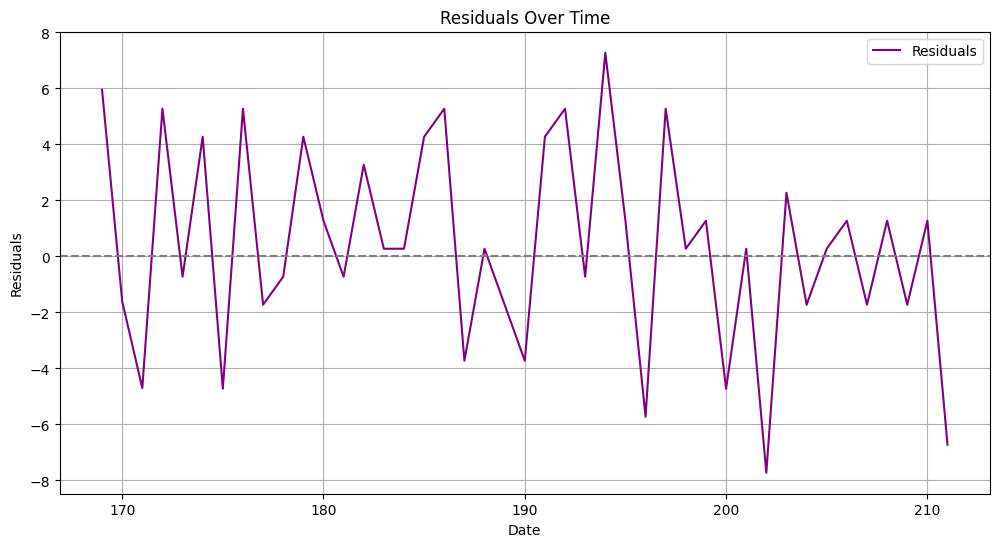

In [15]:
# Residuals
residuals = test - predictions

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()


2. Check Residuals Distribution

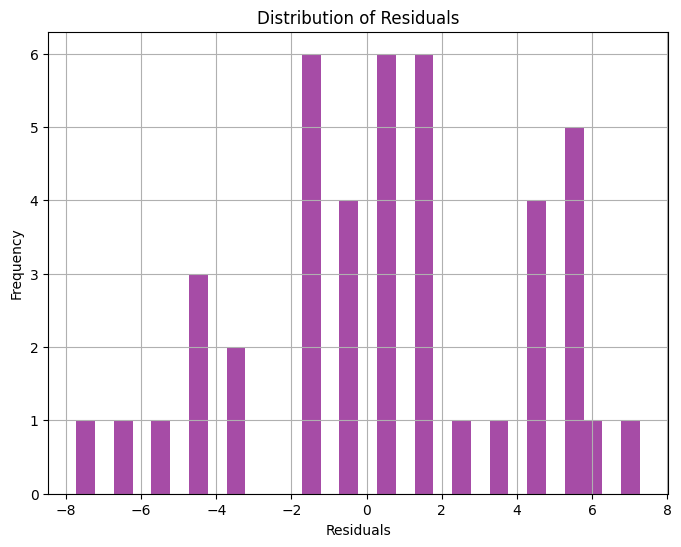

In [16]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()


3. Check Residuals Autocorrelation

<Figure size 800x600 with 0 Axes>

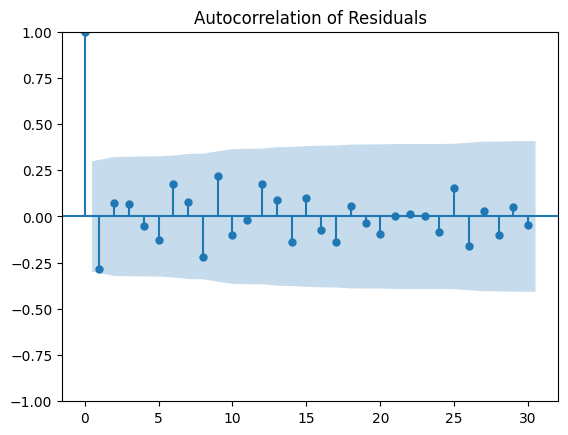

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation of residuals
plt.figure(figsize=(8, 6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of Residuals')
plt.show()


##Step 4: Model Diagnostics
Perform diagnostics to ensure the model is appropriate for the data. This includes analyzing residuals for patterns and verifying assumptions.

1. **Ljung-Box Test**

The Ljung-Box test checks if the residuals are independently distributed.

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)


      lb_stat  lb_pvalue
10  13.127774   0.216615


**Interpretation:**
If the p-value is greater than 0.05, the residuals are independent (no significant autocorrelation).

##Step 5: Forecast Future Values
Generate forecasts for future time periods using the selected model.

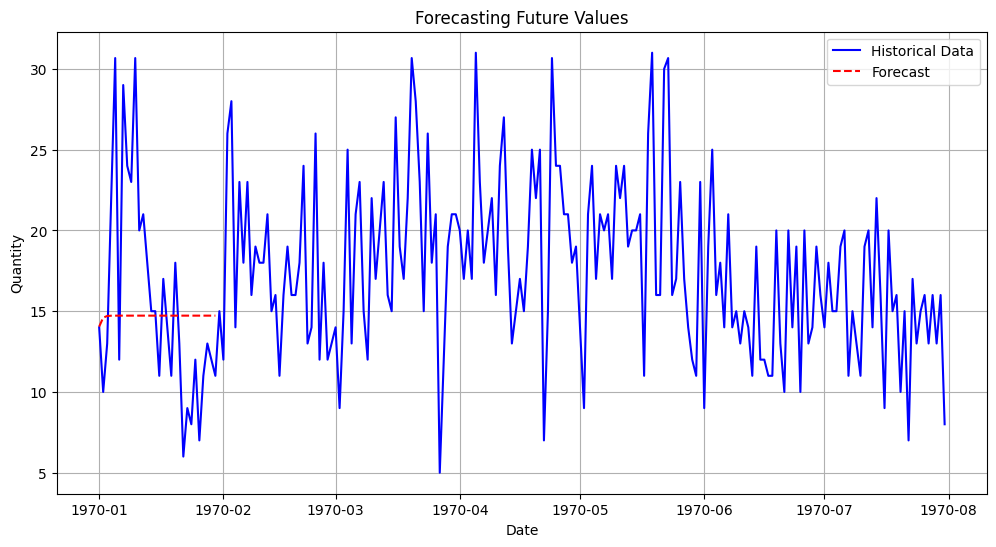

In [19]:
# Forecast future values (e.g., next 30 periods)
future_forecast = fitted_model.forecast(steps=30)

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label="Historical Data", color='blue')
plt.plot(pd.date_range(series.index[-1], periods=30, freq='D'), future_forecast, label="Forecast", color='red', linestyle='--')
plt.title('Forecasting Future Values')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid()
plt.show()


In [57]:
# Example: Store metrics for multiple models
models_metrics = {
    "Model_1": {"MAE": mae_test, "RMSE": rmse_test, "MAPE": mape_test},
    # Add metrics for other models here
}

# Display metrics
for model, metrics in models_metrics.items():
    print(f"{model}: {metrics}")


Model_1: {'MAE': 2.9410815222323348, 'RMSE': 3.6679283843633, 'MAPE': 21.90142368238218}
